<img src="https://raw.githubusercontent.com/earthdaily/Images/main/Corporate/EarthDaily.png" width="20%" alt="EarthDaily Analytics">

# Working with EarthDaily DataCubes
__________________
<a href="https://earthdaily.com/contact/">Give Feedback</a> | <a href="https://github.com/earthdaily">Bug report</a>

**Tags:** #EDS, #EarthMosaics, #EarthDailyConstellation, #EDC, #EarthDailyPython

**Authors**: EarthDaily Analytics

**Last update:** 2024-12-23 (Created: 2024-12-23)

**References:**
- [Earth Daily package](https://github.com/earthdaily/earthdaily-python-client)
- [Earth Data Store documentation](https://earthdaily.github.io/EDA-Documentation/)

## Introduction
EarthDaily Analytics offers access to several [STAC-compliant](https://stacspec.org/en) catalogs of raster data, such as [EarthMosaics](https://earthdaily.com/product-service/earthmosaics/) and [VENuS](https://earthdaily.com/earthdaily-ven%C2%B5s-l2a-cloud-optimized-geotiffs/), as well as maintains development of the [EarthDaily Python Client](https://pypi.org/project/earthdaily/), which acts as a user-friendly access interface to retrieve pixel data as [xarray](https://docs.xarray.dev/en/stable/) objects. Furthermore, xarray datasets returned through the EarthDaily Python Client have several unique features and functionality improvements for convenient remote sensing shorthand analysis. 

## Objectives
This notebook covers details and methods specific to datasets retrieved from the EarthDaily Earth Data Store, covering:
* Native index calculations
* Plotting features
* Zonal Statistics

Import dependencies

In [36]:
import geopandas as gpd
from dotenv import load_dotenv
from odc.stac import stac_load
from shapely.geometry import box

from earthdaily import EDSClient, EDSConfig

### Connecting to EarthDataStore

Loading in environment variables, please update the associated [`EDS.env`](EDS.env), which can be downloaded from the [EarthDaily Account Management page](https://console.earthdaily.com/account).

In [2]:
load_dotenv("EDS.env", override=True)

True

In [3]:
client = EDSClient(EDSConfig())

### Search for Imagery

In [4]:
bbox = (-52.38175462, -29.85496458, -52.07547469, -29.61356083)
start_date = "2024-02-01"
end_date = "2024-12-01"

gdf = gpd.GeoDataFrame({"geometry": [box(*bbox)]}, crs="epsg:4326")

> _**Note:**_ Here we import a small utility function which replaces S3 HREFs with public HTTPS URLs.

In [5]:
from utils import replace_alternate_href

In [32]:
items = client.platform.pystac_client.search(
    collections=["ai-ready-mosaics-sample"], datetime=f"{start_date}/{end_date}", bbox=bbox
)
items_list = list(items.get_all_items())
# Apply href function
[replace_alternate_href(item) for item in items_list]
print(f"Found unique {len(items_list)} items")
items_list

Found unique 2 items


[<Item id=EDA_Mosaic_M_L2A_EM_Mosaic_F9QkJ>,
 <Item id=EDA_Mosaic_M_L2A_EM_Mosaic_8YNF2>]

### Retrieve DataCube

In [33]:
ds = stac_load(
    items_list,
    bands=("red", "green", "blue", "nir08"),
    intersects=gdf,
    crs="epsg:3857",
    resolution=10,
)
ds

<xarray.Dataset> Size: 338MB
Dimensions:      (y: 3096, x: 3411, time: 2)
Coordinates:
  * y            (y) float64 25kB -3.454e+06 -3.454e+06 ... -3.485e+06
  * x            (x) float64 27kB -5.831e+06 -5.831e+06 ... -5.797e+06
    spatial_ref  int32 4B 3857
  * time         (time) datetime64[ns] 16B 2024-02-21T13:40:29.936000 2024-05...
Data variables:
    red          (time, y, x) float32 84MB 1.216e+03 1.201e+03 ... 1.073e+03
    green        (time, y, x) float32 84MB 1.388e+03 1.365e+03 ... 1.085e+03
    blue         (time, y, x) float32 84MB 1.13e+03 1.118e+03 ... 1.025e+03
    nir08        (time, y, x) float32 84MB 4.259e+03 4.171e+03 ... 2.556e+03

# EarthDaily Accessor Datasets
Xarray Datasets returned from the EarthDaily Python Client are serialized with enhanced features, accessible through the associated `EarthDailyAccessorDataset` as shown below:

In [34]:
type(ds.ed)

earthdaily.legacy.accessor.__EarthDailyAccessorDataset

### Plotting RGB
These objects include convenient plotting functionality, such as `plot_rgb`:

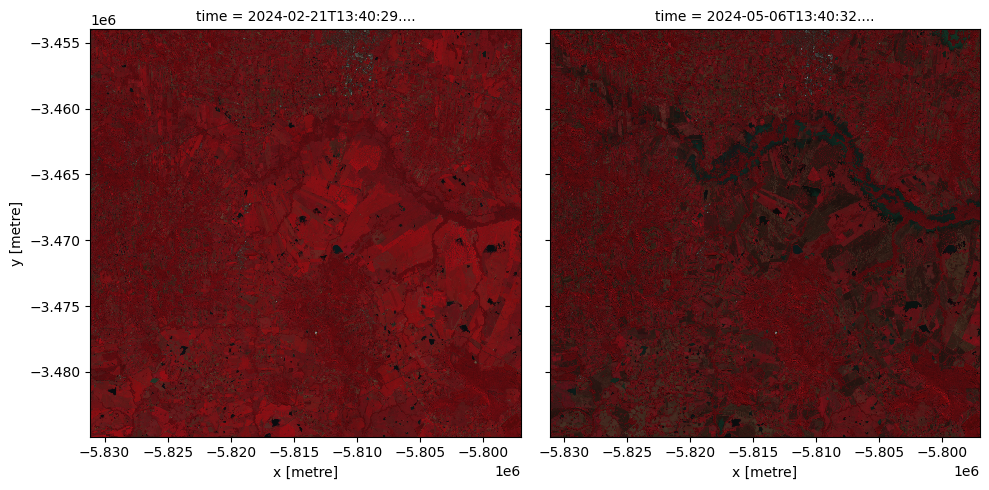

In [35]:
ds.ed.plot_rgb(red="nir08", green="red", blue="green", figsize=(10, 5))

### Index Calculation
These objects also utilize the [Spyndex API](https://spyndex.readthedocs.io/en/latest/reference.html#spyndex-spyndex), allowing for clean index calculations based off the available bands in each dataset:

In [37]:
ds.ed.available_indices()

['BCC',
 'BITM',
 'BIXS',
 'DSWI4',
 'ExG',
 'ExGR',
 'ExR',
 'GCC',
 'GLI',
 'IKAW',
 'MGRVI',
 'MRBVI',
 'NDGlaI',
 'NDTI',
 'NDYI',
 'NGRDI',
 'OSI',
 'RCC',
 'RGBVI',
 'RGRI',
 'RI',
 'RI4XS',
 'SI',
 'TGI',
 'VARI',
 'VIG']

Add NDVI band to the dataset in a single call:

In [38]:
ds = ds.ed.add_indices(["NDVI"], N=ds["nir08"], R=ds["red"])

### Plotting Single-Band Imagery
Use the `plot_band` method for inspecting single-band images:

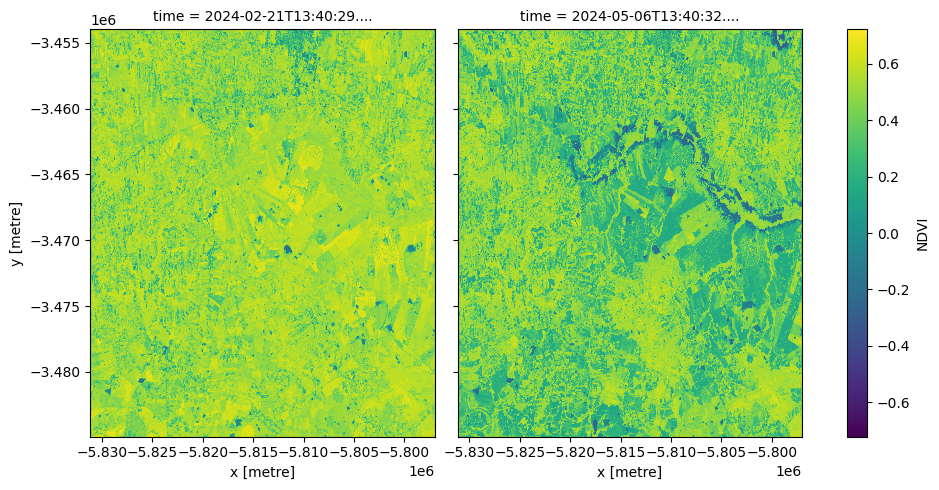

In [39]:
ds.ed.plot_band("NDVI", figsize=(10, 5), cmap="viridis")

### Zonal Statistics
Use the `zonal_stats` method to compute basic summary statistics for a given index:

In [40]:
ds_mean = ds.ed.zonal_stats(gdf)

In [41]:
ds_mean["NDVI"].to_numpy()

array([[[0.48778665]],

       [[0.37530822]]], dtype=float32)

In [42]:
## TODO: Mask polygons - NDVI over fields, reference more advanced use cases in markdown